# エンコーダを学習する

__目次：__

- <a href="#raw2feat">視覚刺激から特徴量を造る</a>
- <a href="#algorun">モデルを初期化してアルゴリズムを走らせる</a>
- <a href="#eval">学習機の出来を評価する</a>
- <a href="#tasks">課題一覧</a>

___

ここでの目的は、これまでに習得してきた技法や知見を融合させ、正常に機能する学習機を造ることである。その応用先は視覚刺激から脳活動へのエンコーディングである。まずはこれまでに用意してきた関数やクラスを`import`しておく。

In [ ]:

import scripts.FilterBank as fb
import scripts.AlgoIntro as ai
import scripts.AlgoSparseReg as asr


作業の流れは下記の通りになる：

    視覚刺激の読み込み --> ガボールフィルタで特徴量を作って保存 --> スパースな線形回帰

これらのタスクを一つずつこなしていく。やり方を明確に伝えるべく、非常に単純なプロトタイプを作っておく。その後の課題では、このプロトタイプをベースにして、エンコーダとしてちゃんと機能するように改善してもらうことになる。

<a id="raw2feat"></a>
## 視覚刺激から特徴量を造る

In [ ]:
import numpy as np
import math

# Import the vim-2 data from the Python binary format we saved earlier.
# Assumptions: that the data is saved in the vim-2 directory,
# already of 96x96 size, with dtype of np.float32.

PIX_W = 96
PIX_H = 96
dtype=np.float32

# Read the raw training data.
shape=(PIX_W,PIX_H,3,108000) # (downsized px, downsized px, rgd channels, time steps)
# Index for temporal down-sampling. Alternatives: do after the feature-building and aggregate.
idx_ds = np.arange(15//2, 108000+1, 15) # need length 7200.
fname = "data/vim-2/X_tr.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    raw_tr = np.fromfile(file=fbin,dtype=dtype).reshape(shape)[:,:,:,idx_ds] # temporally down-sampled.
    print("OK.")

# Check a few frames.
#num_frames = raw_tr.shape[3]
#frames_to_play = 5
#for t in range(frames_to_play):
#    plt.imshow(raw_tr[:,:,:,t])
#    plt.show()


# Read the raw testing data.
shape=(PIX_W,PIX_H,3,8100) # (downsized px, downsized px, rgd channels, time steps)
# Index for temporal down-sampling. Alternatives: do after the feature-building and aggregate.
idx_ds = np.arange(15//2, 8100+1, 15) # need length 540.
fname = "data/vim-2/X_te.dat"
with open(fname, mode="br") as fbin:
    print("Reading...", end=" ")
    raw_te = np.fromfile(file=fbin, dtype=dtype).reshape(shape)[:,:,:,idx_ds] # temporally down-sampled.
    print("OK.")

# Check a few frames.
#num_frames = raw_tr.shape[3]
#frames_to_play = 5
#for t in range(frames_to_play):
#    plt.imshow(raw_tr[:,:,:,t])
#    plt.show()


In [ ]:

# Set up the parameters that specify the first filter bank.
myparas = {"freqs": 32/max(PIX_W,PIX_H),
           "dir": math.pi/2,
           "amp": 0.1,
           "sdev": max(PIX_W,PIX_H)/20,
           "phase": 0}
mygrid_h = 3
mygrid_w = 3

print("Getting features (tr)...", end=" ")
X_tr = fb.G2_getfeatures(ims=raw_tr,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")

print("Getting features (te)...", end=" ")
X_te = fb.G2_getfeatures(ims=raw_te,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")


In [ ]:
print("Shape of the produced features:")
print("tr:", X_tr.shape)
print("te:", X_te.shape)

上のパラメータだけでは、特徴量が非常に少なく、説明能力が到底足りない。増やす方法はいくらでもあるが、別のdictを一つ用意し、特徴量ベクトルを連結させる事例を次に示しておく。

In [ ]:
# Set up the parameters that specify the second filter bank.
myparas = {"freqs": 32/max(PIX_W,PIX_H),
           "dir": 0,
           "amp": 0.1,
           "sdev": max(PIX_W,PIX_H)/20,
           "phase": 0}
mygrid_h = 9
mygrid_w = 9

print("Getting features (tr)...", end=" ")
tmp_X = fb.G2_getfeatures(ims=raw_tr,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")
X_tr = np.concatenate((X_tr, tmp_X), axis=1) # concatenate!

print("Getting features (te)...", end=" ")
tmp_X = fb.G2_getfeatures(ims=raw_te,
                         fil_paras=myparas,
                         gridshape=(mygrid_h,mygrid_w),
                         mode="reflect", cval=0)
print("OK.")
X_te = np.concatenate((X_te, tmp_X), axis=1) # concatenate!

print("Shape of the produced features:")
print("tr:", X_tr.shape)
print("te:", X_te.shape)

上から明らかなように、連結させることで、データ行列に列を追加しているだけである。行数（つまりサンプル数）は一定である。

これまでと同様に、Nishimoto et al. (2011)にしたがって、特徴量のZスコアを計算する（平均ゼロ、分散1.0の標準化）。これをした上で、「外れ値」と見なすべき点の閾値を定め、必要に応じて切断する。公平な学習課題になるように、訓練・検証を別々に扱う。

In [ ]:

X_tr = X_tr - np.mean(X_tr, axis=0)
X_tr = X_tr / np.std(X_tr, axis=0)
print("Mean =", np.mean(X_tr, axis=0), "StdDev =", np.std(X_tr, axis=0))

X_te = X_te - np.mean(X_te, axis=0)
X_te = X_te / np.std(X_te, axis=0)
print("Mean =", np.mean(X_te, axis=0), "StdDev =", np.std(X_te, axis=0))

for j in range(X_tr.shape[1]):
    stdval = np.std(X_tr[:,j])
    X_tr[:,j] = np.clip(X_tr[:,j], a_min=(-stdval), a_max=stdval)
    stdval = np.std(X_te[:,j])
    X_te[:,j] = np.clip(X_te[:,j], a_min=(-stdval), a_max=stdval)


思い通りにこれまでの計算ができているのであれば、整列された全特徴量をディスクに書き込み、付属data infoオブジェクトも併せて用意する。

In [ ]:
import support.classes as classes

# Make a data_info file for this data, and save as data/encoder/info.dat.
dinfo = classes.DataInfo()
dinfo.mname = "Encoder"

fname = "data/encoder/X_tr.dat"
dtype = raw_tr.dtype
shape = raw_tr.shape
with open(fname, mode="bw") as fbin:
    X_tr.tofile(fbin)
    print("Saved to file.")
dinfo.X_tr["shape"] = X_tr.shape
dinfo.X_tr["path"] = "data/encoder/X_tr.dat"
dinfo.X_tr["dtype"] = X_tr.dtype
    
fname = "data/encoder/X_te.dat"
dtype = raw_te.dtype
shape = raw_te.shape
with open(fname, mode="bw") as fbin:
    X_te.tofile(fbin)
    print("Saved to file.")
dinfo.X_te["shape"] = X_te.shape
dinfo.X_te["path"] = "data/encoder/X_te.dat"
dinfo.X_te["dtype"] = X_te.dtype

In [ ]:
import support.classes as classes

# Make a data_info file for this data, and save as data/encoder/info.dat.
dinfo = classes.DataInfo()
dinfo.mname = "Encoder"

fname = "data/encoder/X_tr.dat"
dtype = raw_tr.dtype
shape = raw_tr.shape
with open(fname, mode="bw") as fbin:
    X_tr.tofile(fbin)
    print("Saved to file.")
dinfo.X_tr["shape"] = X_tr.shape
dinfo.X_tr["path"] = "data/encoder/X_tr.dat"
dinfo.X_tr["dtype"] = X_tr.dtype

fname = "data/encoder/X_te.dat"
dtype = raw_te.dtype
shape = raw_te.shape
with open(fname, mode="bw") as fbin:
    X_te.tofile(fbin)
    print("Saved to file.")
dinfo.X_te["shape"] = X_te.shape
dinfo.X_te["path"] = "data/encoder/X_te.dat"
dinfo.X_te["dtype"] = X_te.dtype

# Clear the raw data from memory.
del [raw_te, raw_tr]


応答に関しては、特別な処理は何も要らないので、`encoder`ディレクトリへ移すだけで十分である。

```
$ mv data/vim-2/y_tr.dat data/vim-2/y_te.dat ./data/encoder/
$ mv data/vim-2/cleanidx_tr.dat data/vim-2/cleanidx_te.dat ./data/encoder/

```

`dinfo`の残りの空欄を埋めてからディスクに書き込む。

In [ ]:

import pickle

fname = "data/encoder/y_tr.dat"
dinfo.y_tr["shape"] = (73728, 7200)
dinfo.y_tr["path"] = "data/encoder/y_tr.dat"
dinfo.y_tr["dtype"] = np.float32

fname = "data/encoder/y_te.dat"
dinfo.y_te["shape"] = (73728, 540)
dinfo.y_te["path"] = "data/encoder/y_te.dat"
dinfo.y_te["dtype"] = np.float32

dinfo.misc = {"voxidx": None} # to be filled in later.

with open("data/encoder/info.dat", mode="bw") as fbin:
    pickle.dump(dinfo, fbin)
    print("Saved to file.")


<a id="algorun"></a>
## モデルを初期化してアルゴリズムを走らせる

特徴量の準備が整っているなら、Jupyterのカーネルをリセットし、ここから新たな作業を始める。

前回で作った`Algo_LASSO_CD`をここで本領発揮してもらう。前回のテストとまったく同様に、多数の$\lambda$候補を用意し、warm startを生かしながら学習させていく。

パフォーマンス評価指標として、Nishimoto et al. (2011)より：

> *"Prediction accuracy was defined as the correlation between predicted and observed BOLD signals. The averaged accuracy across subjects and voxels in early visual areas (V1, V2, V3, V3A, and V3B) was 0.24, 0.39, and 0.40 for the static, nondirectional, and directional encoding models, respectively."*

教育目的なので我々の学習機があらゆる意味で彼らのものに劣っているのだが、めざす基準としてはこの数値には意義がある。特に相関係数0.24は、2次元のガボールフィルタを使ったときに出た数字なので、より現実的な基準と見てもよかろう。

算出方法は次の通りである。訓練データを使って、学習アルゴリズムを一通り走らせると、$\widehat{w}$に対応する`w_est`が定まる。線形モデルを使っているので、新しい入力$X$から$\widehat{y} = X\widehat{w}$を出して、$\widehat{y} \approx y$で近似してみる。この$X$と$y$が`X_te`と`y_te`に対応する。予測信号と本当の信号の相関が強いほどよいということなので、下記の通りに相関係数を出す：

\begin{align}
\text{corr}\,(\widehat{y},y) = \frac{\text{cov}\,(\widehat{y},y)}{\sqrt{\text{var}\,(\widehat{y})\text{var}\,(y)}},
\end{align}

これは`scipy.stats.pearsonr`で計算できる。また、予測・真の平均的な2乗誤差（root mean squared error; RMSE）を求めることもできる：

\begin{align}
\text{RMSE}\,(\widehat{y},y) = \left( \frac{1}{m} \sum_{i=1}^{m} (\widehat{y}_{i}-y_{i})^2 \right)^{1/2},
\end{align}

これはモデルオブジェクトの`mod.eval`というメソッドで実装している。$m$は検証データのサンプル数（ここでは$m=540$）。


In [1]:

import numpy as np
import math
import pickle
import support.parse_model as mp
import scripts.AlgoSparseReg as asr

# Load the general data info object.
with open("data/encoder/info.dat", mode="br") as fbin:
    dinfo = pickle.load(fbin)

# Load the clean index, extracting indices from binary indicators.
with open("data/encoder/cleanidx_tr.dat", mode="br") as fbin:
    #cleanidx_tr_RAW = np.fromfile(file=fbin, dtype=np.uint32)
    cleanidx_tr = np.flatnonzero(np.fromfile(file=fbin, dtype=np.uint32))
    print("length:", cleanidx_tr.size)
with open("data/encoder/cleanidx_te.dat", mode="br") as fbin:
    #cleanidx_te_RAW = np.fromfile(file=fbin, dtype=np.uint32)
    cleanidx_te = np.flatnonzero(np.fromfile(file=fbin, dtype=np.uint32))
    print("length:", cleanidx_te.size)
    
# Take the intersection of the clean voxel indices and sort.
cleanidx = np.intersect1d(cleanidx_tr,cleanidx_te)
print(cleanidx_tr)
print(cleanidx_te)
print("cleanidx length:", cleanidx.size)

# Load the data info object. We shall modify its voxel index on the fly.
with open("data/encoder/info.dat", mode="br") as fbin:
    dinfo = pickle.load(fbin)
    print(dinfo)

# Initialize model and weights for an individual voxel.
dinfo.misc["voxidx"] = cleanidx[0]
mod = mp.model(dinfo)
w_init = mod.w_initialize()


lam_min = 1 / mod.n

# TODO: set the START and STOP guys with proper computations using mod.X_tr and mod.y_tr.
todo_lambda = np.flipud(np.logspace(start=math.log10(lam_min),
                                    stop=math.log10(1),
                                    num=150))

# Store performance metric statistics for each lambda setting.
err_overlam = np.zeros(todo_lambda.size, dtype=np.float32)
corr_overlam = np.zeros(todo_lambda.size, dtype=np.float32)
spar_overlam = np.zeros(todo_lambda.size, dtype=np.float32)



length: 59928
length: 63050
[ 4355  4356  4357 ... 73567 73568 73569]
[  300   301   302 ... 73725 73726 73727]
cleanidx length: 59928
X_tr: {'shape': (7200, 90), 'path': 'data/encoder/X_tr.dat', 'dtype': dtype('float32')}
X_te: {'shape': (540, 90), 'path': 'data/encoder/X_te.dat', 'dtype': dtype('float32')}
y_tr: {'shape': (73728, 7200), 'path': 'data/encoder/y_tr.dat', 'dtype': <class 'numpy.float32'>}
y_te: {'shape': (73728, 540), 'path': 'data/encoder/y_te.dat', 'dtype': <class 'numpy.float32'>}
mname: Encoder
misc: {'voxidx': None}


In [2]:
# Iterate over the lambda values once, for a single candidate.
print("Working...")
for i in range(todo_lambda.size):
    
    # Initialize and execute the algorithm.
    al = asr.Algo_LASSO_CD(w_init=w_init,\
                           t_max=20*w_init.size,\
                           lam_l1=todo_lambda[i],\
                           verbose=False)
    
    for mystep in al:
        al.update(model=mod)
    
    # Record performance.
    w_est = al.w
    err_overlam[i] = mod.eval(w_est)[0]
    if np.std(np.dot(mod.X_te, w_est)) > 0:
        corrval = mod.corr_te(w_est)
    else:
        corrval = 0  # watch out for zero-variance case.
    corr_overlam[i] = corrval
    spar_overlam[i] = np.count_nonzero(w_est)
    
    # Update the initializer to the most current observation.
    w_init = w_est

print("Done.")

Working...
Done.


学習が終わると、その生の成績を`raw/encoder`というディレクトリに保存しておく。

In [3]:
with open("raw/encoder/lasso01_lam.raw", mode="bw") as fbin:
    pickle.dump(todo_lambda, fbin)
    print("Saved to file.")

with open("raw/encoder/lasso01_err.raw", mode="bw") as fbin:
    pickle.dump(err_overlam, fbin)
    print("Saved to file.")
    
with open("raw/encoder/lasso01_corr.raw", mode="bw") as fbin:
    pickle.dump(corr_overlam, fbin)
    print("Saved to file.")
    
with open("raw/encoder/lasso01_spar.raw", mode="bw") as fbin:
    pickle.dump(spar_overlam, fbin)
    print("Saved to file.")

Saved to file.
Saved to file.
Saved to file.
Saved to file.


<a id="eval"></a>
## 学習機の出来を評価する

学習が終わって、あとは成績を集計したり、可視化したりするだけである。
Jupyterのカーネルをリセットし、ここから新たな作業を始める。

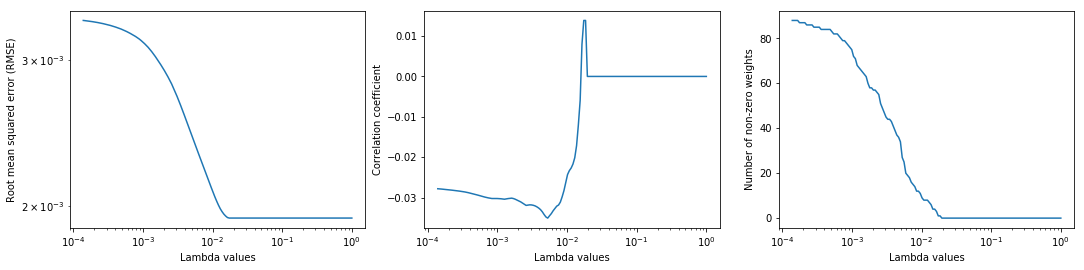

In [2]:
import pickle
import matplotlib
import matplotlib.pyplot as plt

with open("raw/encoder/lasso01_lam.raw", mode="br") as fbin:
    todo_lambda = pickle.load(fbin)

with open("raw/encoder/lasso01_err.raw", mode="br") as fbin:
    err_overlam = pickle.load(fbin)
    
with open("raw/encoder/lasso01_corr.raw", mode="br") as fbin:
    corr_overlam = pickle.load(fbin)
    
with open("raw/encoder/lasso01_spar.raw", mode="br") as fbin:
    spar_overlam = pickle.load(fbin)

myfig = plt.figure(figsize=(18,4))
ax_err = myfig.add_subplot(1, 3, 1)
plt.ylabel("Root mean squared error (RMSE)")
plt.xlabel("Lambda values")
ax_err.set_yscale('log')
ax_err.set_xscale('log')
ax_err.plot(todo_lambda, err_overlam)

ax_corr = myfig.add_subplot(1, 3, 2)
plt.ylabel("Correlation coefficient")
plt.xlabel("Lambda values")
ax_corr.set_xscale('log')
ax_corr.plot(todo_lambda, corr_overlam)

ax_spar = myfig.add_subplot(1, 3, 3)
plt.ylabel("Number of non-zero weights")
plt.xlabel("Lambda values")
ax_spar.set_xscale('log')
ax_spar.plot(todo_lambda, spar_overlam)

plt.show()

明らかなように、これほど単純なモデルと恣意的な学習アルゴリズムの設定では、まったく予測ができない。

さまざまな要因はあるが、特に注視すべき改善点は下記の通りである。

- 初期値`w_init`の決め方。

- $\lambda$の候補の範囲と密度。

- 学習機の反復回数の制限`t_max`。

- フィルタバンクを定めるあらゆるパラメータが大事だが、特に重要なのは`freqs`、`dir`、`sdev`であろう。

- フィルタバンクの豊富さ。グリッドの解像度の高低、多様な空間周波数、向きなどをまんべんなく含むことが必須。

これらの改善点を念頭において、次の「課題一覧」の練習問題に取り組んでください。

<a id="tasks"></a>
## 課題一覧

0. すべてのボクセル分の学習をする必要はなく、Nishimoto et al.のいう「early visual areas」に焦点を当てること。それは両半球においてV1、V2、V3、V3A、V3BというROIのことを指す。訓練データを使い、これらのすべてのクリーンなボクセルを対象に学習させ、検証データにおいて、訓練データでもっとも良かった$\lambda$のときの学習結果の成績を算出すること。ROIごとに、これらの成績（相関係数等）のボクセルの上での平均と分散を求めること。

0. 特徴量の配列を連結させることで、様々なフィルタからの特徴量を利用することができる。実際、良い説明能力を実現しようと思えば、おそらく不可欠な作業であろう。引用している論文でも、多数の空間周波数と向きの組み合わせが使われている。課題として、互いに異なる特徴量を捉えるフィルタバンクを２つ以上用意し、それぞれを学習用の使うこと。そのROIごとに結果を踏まえて、どの領域でどのような情報が必要かと思われるか。また、脳の部位の「選択性」について何がいえるか。

0. 先の課題を、全被験者分のデータを使って行なうこと。被験者の間、同じモデルとアルゴリズムを使って、パフォーマンスに差異があるか。被験者の上でも平均的な成績を求めて、引用している論文の成績と勝負できるか。

0. 手法の更なる強化を測るため、時間の遅延を利用して特徴量を作ることができる。つまり、前の時点の特徴量ベクトルを、現時点の特徴量ベクトルに連結させるという方法。現時点の特徴量を$x_{i}$とすると、$x_{i-1}$が前の時点に相当するので、連結した結果が$\widetilde{x}_{i} = (x_{i},x_{i-1})$になって、この$\widetilde{x}_{i}$を学習に使うことになる。遅延が$k$時点なら、$\widetilde{x}_{i} = (x_{i},x_{i-1},\ldots,x_{i-k})$となる。数ステップを試して、パフォーマンスがもっとも良い遅延はいくらか。

0. 学習結果の良し悪しがROIによってどの程度変わるか。特段良い・悪い成績が見られたROIがあれば、それはどれか。

0. モデルは大事だが、学習アルゴリズムもきわめて大きな役割を果たす。ベストな設定を探るべく、反復回数などの終了条件や$\lambda$の候補範囲、その他のアルゴリズムの工夫を調べること。どのようなアルゴリズム設定がもっとも良い成績につながったか。独自の改造を行った場合、それも併せて説明すること。

0. （おまけ）これまでは同一被験者を前提として、「汎化能力」を評価してきた。当然ながら、被験者間の汎化能力も注目に値する。つまり、2名の被験者のデータを足し合わせて、大きなデータセットにまとめ、訓練データとして使って学習してから、残り1名の被験者のデータを検証データとする。同じモデルとアルゴリズムでも十分なのか。それとも、新たな工夫が必要だったか。また、このときの汎化能力の解釈が、被験者ごとに学習する場合と比べて、どう違うか。


## 参考文献：

 - Nishimoto, Shinji, et al. "Reconstructing visual experiences from brain activity evoked by natural movies." Current Biology 21.19 (2011): 1641-1646.
 - Description of dataset vim-2 (visual imaging 2), at CRCNS - Collaborative Research in Computational Neuroscience. https://crcns.org/data-sets/vc/vim-2/about-vim-2